In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score

import warnings
warnings.filterwarnings("ignore")

### Slight Cleaning 

- Set all string variables to have uniformly lower case letters
- Try out setting latitude longitude to numeric
- Drop missing lat/long

In [37]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')

for col in data.columns:
    if data[col].dtype == 'object': 
        data[col] = data[col].str.lower()


data = data[~(data['damage']=='UNK')]

for i in ['latitude','longitude']:
    data[i].replace('other/unknown',np.nan,inplace=True)
data = data.dropna().reset_index()

data['latitude'] = data['latitude'].str[:-1].astype('int')
data['longitude'] = data['longitude'].str[:-1].astype('int')


In [38]:
data['damage'].value_counts(normalize=True)

damage
subs    0.897267
dest    0.086977
unk     0.009164
minr    0.006592
Name: proportion, dtype: float64

### Note on class imbalance:
- Almost 90% of our accidents are "substantial."  I think that, given this massive imbalance, we may have to switch the target variable to the second-highest category, which is destroyed, to capture some level of variation.  
- However, it is worth trying some preliminary anlayses to see how different learners (I exclude some others have used in different notebooks)

In [39]:
features = ['latitude', 'longitude',
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown']

target = ['damage']

X = data[features]
y = data[target]

### Train test split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

In [41]:
X_train.shape

(8708, 49)

### Grid search: Histogram Gradient Boost & Extra Trees Classifiers

In [42]:
histgrad = HistGradientBoostingClassifier()

# GridSearch 
param_grid = {
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'max_iter': [100,200,500],
    'max_leaf_nodes': [3,6]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'max_iter': [100, 200, 500],
                         'max_leaf_nodes': [3, 6]},
             scoring='f1_macro')

In [43]:
grid.best_estimator_

HistGradientBoostingClassifier(max_leaf_nodes=6)

In [44]:
grid.best_params_

{'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 6}

In [45]:
grid.best_score_

np.float64(0.42175556250365254)

### Extra Trees

In [46]:
extrees = ExtraTreesClassifier()

# GridSearch 
param_grid = {
    'max_depth': [2,10,50,100,1000],
    'n_estimators': [10,100,500,1000],
    'max_leaf_nodes': [3,6,36,90]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [2, 10, 50, 100, 1000],
                         'max_leaf_nodes': [3, 6, 36, 90],
                         'n_estimators': [10, 100, 500, 1000]},
             scoring='f1_macro')

In [47]:
grid.best_estimator_

ExtraTreesClassifier(max_depth=100, max_leaf_nodes=90, n_estimators=10)

In [48]:
grid.best_params_

{'max_depth': 100, 'max_leaf_nodes': 90, 'n_estimators': 10}

In [49]:
grid.best_score_

np.float64(0.3835891970861338)

# Testing "Destroyed" Binary Classification Learner
- Re-creates the dataset, but the target becomes a binary "was the aircraft destroyed" indicator (900/~10000 observations)
- See if switch from multiclass to binary target leads to increase in performance
  

In [50]:
data = pd.read_csv('../data/ntsb_processed/ntsb_train_cleaned.csv')

for col in data.columns:
    if data[col].dtype == 'object': 
        data[col] = data[col].str.lower()


data = data[~(data['damage']=='UNK')]

for i in ['latitude','longitude']:
    data[i].replace('other/unknown',np.nan,inplace=True)
data = data.dropna().reset_index()

data['latitude'] = data['latitude'].str[:-1].astype('int')
data['longitude'] = data['longitude'].str[:-1].astype('int')

damage = pd.get_dummies(data['damage'],dtype='int') # Dummy out target 
data['destroyed'] = damage['dest'] # Create binary classifier

In [51]:
features = ['latitude', 'longitude',
       'apt_dist', 'gust_kts', 'altimeter',
       'aircraft_count', 'num_eng', 'days_since_insp', 'light_cond_DAYL', 'light_cond_DUSK',
       'light_cond_NDRK', 'light_cond_NITE', 'light_cond_other/unknown',
       'BroadPhaseofFlight_Air', 'BroadPhaseofFlight_Ground',
       'BroadPhaseofFlight_Landing', 'BroadPhaseofFlight_Takeoff',
       'BroadPhaseofFlight_other/unknown', 'eng_type_REC', 'eng_type_TF',
       'eng_type_TP', 'eng_type_TS', 'eng_type_other/unknown', 'far_part_091',
       'far_part_121', 'far_part_135', 'far_part_137', 'far_part_PUBU',
       'far_part_other/unknown', 'acft_make_beech', 'acft_make_bell',
       'acft_make_boeing', 'acft_make_cessna', 'acft_make_mooney',
       'acft_make_other/unknown', 'acft_make_piper',
       'acft_make_robinson helicopter', 'acft_category_AIR',
       'acft_category_HELI', 'acft_category_other/unknown', 'homebuilt_N',
       'homebuilt_Y', 'homebuilt_other/unknown', 'fixed_retractable_FIXD',
       'fixed_retractable_RETR', 'fixed_retractable_other/unknown',
       'second_pilot_N', 'second_pilot_Y', 'second_pilot_other/unknown']

target = ['destroyed']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=2025)

In [52]:
y.value_counts()

destroyed
0            11358
1             1082
Name: count, dtype: int64

In [53]:
#data.columns

In [54]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty=None)

## fit the model
log_reg.fit(X_train,y_train)


LogisticRegression(penalty=None)

In [55]:
# Calculate accuracy on the test set
test_accuracy = log_reg.score(X_val, y_val)
print(f"Test Accuracy (model.score()): {test_accuracy:.4f}")

# Alternatively, predict and use accuracy_score
y_pred = log_reg.predict(X_val)
accuracy_from_metric = accuracy_score(y_val, y_pred)
print(f"Test Accuracy (accuracy_score): {accuracy_from_metric:.4f}")

Test Accuracy (model.score()): 0.9129
Test Accuracy (accuracy_score): 0.9129


In [56]:
confusion_matrix(y_pred,y_val)

array([[3407,  325],
       [   0,    0]])

In [57]:
histgrad = HistGradientBoostingClassifier()

# GridSearch 
param_grid = {
    'learning_rate': [0.01,0.05,0.1,0.5,1],
    'max_iter': [100,200,500],
    'max_leaf_nodes': [3,6]
}

grid = GridSearchCV(
    histgrad,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
                         'max_iter': [100, 200, 500],
                         'max_leaf_nodes': [3, 6]},
             scoring='f1_macro')

In [58]:
model = grid.best_estimator_
model

HistGradientBoostingClassifier(learning_rate=1, max_iter=500, max_leaf_nodes=3)

In [59]:
grid.best_score_

np.float64(0.5546124544102266)

In [60]:
probs = pd.DataFrame(model.predict_proba(X_val))

In [61]:
probs

,0,1
0,0.984242,0.015758
1,0.999556,0.000444
2,0.999915,0.000085
3,0.854526,0.145474
4,0.890946,0.109054
...,...,...
3727,0.890905,0.109095
3728,0.999021,0.000979
3729,0.702905,0.297095
3730,0.990815,0.009185


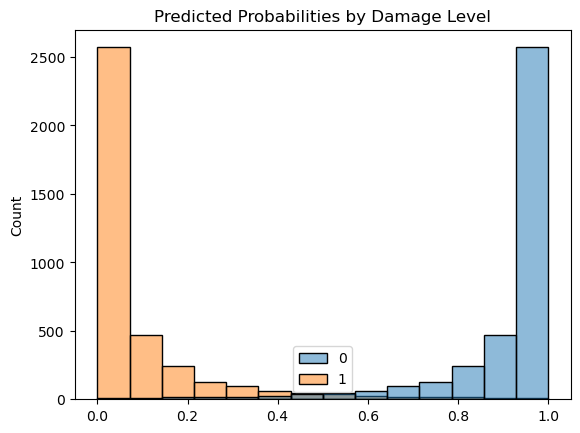

In [62]:
sns.histplot(probs)
plt.title("Predicted Probabilities by Damage Level")
plt.show()

In [63]:
len(probs[probs[1] > 0.50]) / len(y_train)

0.014584290307762976

In [64]:
y.mean()

destroyed    0.086977
dtype: float64

<Axes: >

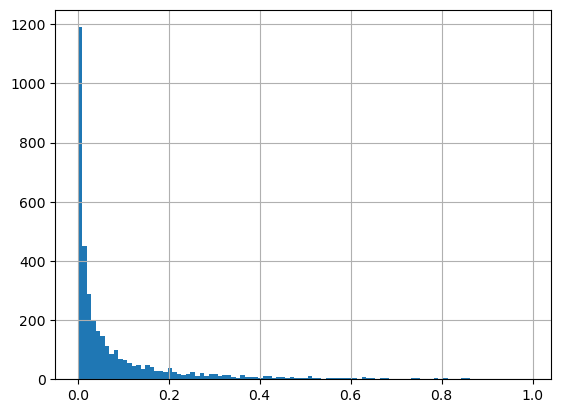

In [65]:
probs[1].hist(bins=100)

#### Note:
This plot of the predicted probabilities of the "destroyed" binary measure shows that we have very few observations whose probability of being "destroyed" is greater than 0.5 - only 1.4% of the training data have a probability of being destroyed despite 8% actually being destroyed.  I am unsure as to how to best proceed.

### Extra Trees Binary Classifier

In [66]:
extrees = ExtraTreesClassifier()

# GridSearch 
param_grid = {
    'max_depth': [2,10,50,100,1000],
    'n_estimators': [10,100,500,1000],
    'max_leaf_nodes': [3,6,36,90]
}

grid = GridSearchCV(
    extrees,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [2, 10, 50, 100, 1000],
                         'max_leaf_nodes': [3, 6, 36, 90],
                         'n_estimators': [10, 100, 500, 1000]},
             scoring='f1_macro')

In [67]:
grid.best_score_

np.float64(0.4836488730516109)

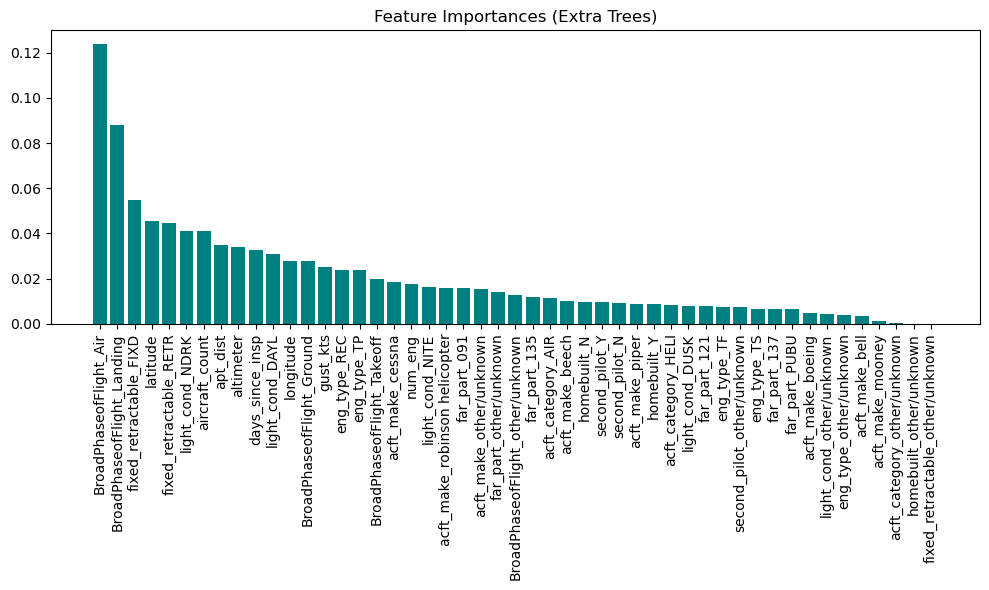

In [68]:
model = grid.best_estimator_
importances = model.feature_importances_
feats = X_train.columns


indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Extra Trees)")
plt.bar(range(len(feats)), importances[indices], color="teal", align="center")
plt.xticks(range(len(feats)), [feats[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Testing a Dumb Learner
- Out of interest, I am going to create a learner which only predicts non-destroyed planes and see how its performance compares to our "smarter" learners.

In [69]:
y_dumb = np.zeros(len(y_train))
f1_score(y_dumb,y_train,average='macro')

0.4772795485923525

In [70]:
y_dumb = np.zeros(len(y_val))
f1_score(y_dumb,y_val,average='macro')

0.4772377083625158

Sadly, our "dumb" learner performs basically as well as our other learner...

# Regression with Proportion of Serious/Fatal as Target

In [71]:
data['prop_sf'] = data['acft_prop_inj_f'] + data['acft_prop_inj_s']

prop_sf
0.000000    9033
1.000000    2826
0.500000     320
0.333333      48
0.250000      46
            ... 
0.024691       1
0.005376       1
0.005291       1
0.007143       1
0.062500       1
Name: count, Length: 93, dtype: int64

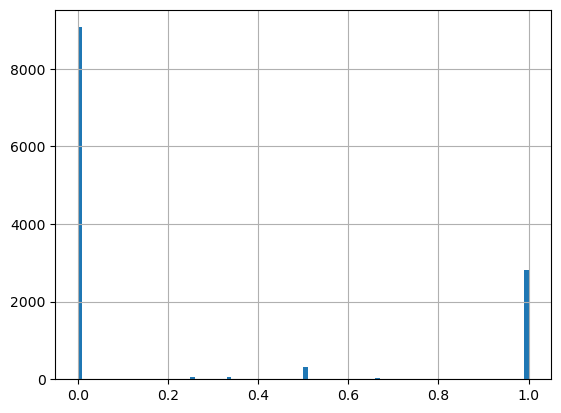

In [72]:
data['prop_sf'].hist(bins=100)
data.prop_sf.value_counts()

In [73]:
target = ['prop_sf']
X = data[features]
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=2025)

#### Note:
Again, we have pretty extreme imbalance in the variable - most are not injured seriously or more, while others are 100% serious or more, with little population between the two.  

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [75]:
rf = RandomForestRegressor()

# GridSearch 
param_grid = {
    'n_estimators':[10,500,1000],
    'min_samples_leaf':[2,5,10],
    'max_samples':[100,500,1000]
}

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1_macro',
    cv=5,
)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_samples': [100, 500, 1000],
                         'min_samples_leaf': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             scoring='f1_macro')

In [76]:
model = grid.best_estimator_
model

RandomForestRegressor(max_samples=100, min_samples_leaf=2, n_estimators=10)

Train set score

In [82]:
y_pred =model.predict(X_train)
print(f'MSE: {mean_squared_error(y_pred,y_train)}')
print(f'MAE: {mean_absolute_error(y_pred,y_train)}')

MSE: 0.16569820821490794
MAE: 0.33685341689964526


Validation set score

In [80]:
y_pred =model.predict(X_val)

In [81]:
print(f'MSE: {mean_squared_error(y_pred,y_val)}')
print(f'MAE: {mean_absolute_error(y_pred,y_val)}')

MSE: 0.17119867780600662
MAE: 0.3432183748516027


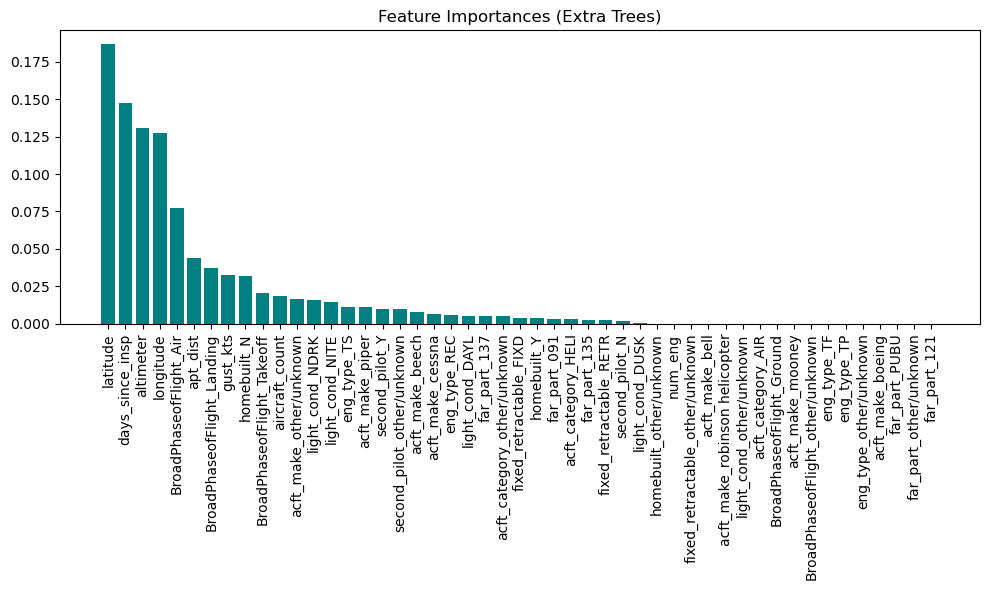

In [79]:
importances = model.feature_importances_
feats = X_train.columns


indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Extra Trees)")
plt.bar(range(len(feats)), importances[indices], color="teal", align="center")
plt.xticks(range(len(feats)), [feats[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()